## Data Understanding

note dr mba zev
1. buat yg varmax belum ditampilkan lag acf dan pacf dari setiap variabel
 2. apabila lag yang signifikan adalah setiap kelipatan 7 dan datanya harian maka menunjukkan bahwa seasonalnya 7 atau mingguan jd variabel dummy yang perlu digenerate adalah week bukan day

## Feature Explanation



* store_nbr 		: Nama toko tempat produk terjual
* family 		: Jenis produk yang dijual di toko tersebut.
* sales 			: Jumlah penjualan produk pada satuan tertentu.
* onpromotion 	: Jumlah item produk yang dipromosikan.
* Dcoilwtico 		: Harga minyak mentah di West Texas Intermediate Cushing, Oklahoma
* Time Range		: 1 Jan 2013 - 15 Ags 2017 (Data harian)



## Family feature explanation

Feature family terdiri dar 33 category :
* AUTOMOTIVE                    
* HOME APPLIANCES               
* SCHOOL AND OFFICE SUPPLIES    
* PRODUCE                       
* PREPARED FOODS                
* POULTRY                       
* PLAYERS AND ELECTRONICS       
* PET SUPPLIES                  
* PERSONAL CARE                 
* MEATS                         
* MAGAZINES                     
* LIQUOR,WINE,BEER              
* LINGERIE                      
* LAWN AND GARDEN               
* LADIESWEAR                    
* HOME CARE                     
* HOME AND KITCHEN II           
* BABY CARE                     
* HOME AND KITCHEN I            
* HARDWARE                      
* GROCERY II                    
* GROCERY I                     
* FROZEN FOODS                  
* EGGS                          
* DELI                          
* DAIRY                         
* CLEANING                      
* CELEBRATION                   
* BREAD/BAKERY                  
* BOOKS                        
* BEVERAGES                     
* BEAUTY                        
* SEAFOOD                                           


## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras import metrics
import sklearn as sk
import keras

## EDA

Informasi tentang dataset yang digunakan

>[Information of dataset](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/CefiroMartha/Store5/refs/heads/main/store5.csv')
data.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [ ]:
# melihat statistik deskriptive sederhana
col_num = [x for x in data.columns if data[x].dtype != 'object' and x not in ['id', 'date', 'store_nbr','family']]
data[col_num].describe()

,sales,onpromotion,dcoilwtico
count,55572.000000,55572.000000,38379.000000
mean,280.580231,2.687864,67.925589
std,652.588149,11.748996,25.666659
min,0.000000,0.000000,26.190000
25%,1.000000,0.000000,46.380000
50%,19.000000,0.000000,53.330000
75%,237.000000,0.000000,95.800000
max,8216.620000,182.000000,110.620000


In [ ]:
# melihat nilai unik dari setiap feature
def number_unique(df):
  for i in df.columns:
    print(f'kolom {i} memiliki {df[i].nunique()} nilai unik')

number_unique(data)

kolom id memiliki 55572 nilai unik
kolom date memiliki 1684 nilai unik
kolom store_nbr memiliki 1 nilai unik
kolom family memiliki 33 nilai unik
kolom sales memiliki 14753 nilai unik
kolom onpromotion memiliki 165 nilai unik
kolom dcoilwtico memiliki 994 nilai unik


In [ ]:
# Melihat jumlah dari setiap kategori di dalam feature
def number_counts(df):
  for i in df.columns:
    if i in ['id', 'date', 'store_nbr']:
      continue
    else:
      print(f'===========\n')
      print(f'kolom {i} \n{df[i].value_counts()}')

number_counts(data)


kolom family 
family
AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   168

In [ ]:
# Cek Missing Value
data.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
dcoilwtico,17193


**Note** : niai o pada feature **sales & on promotion** bukan mengintepretasikan missing value

In [ ]:
# copy data asli ke df
df = data.copy()

# set df dengan drop [id, store_nbr] dan index adalah date
df.drop(columns=['id', 'store_nbr'], inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head()

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.0,0,NaN
2013-01-01,BABY CARE,0.0,0,NaN
2013-01-01,BEAUTY,0.0,0,NaN
2013-01-01,BEVERAGES,0.0,0,NaN
2013-01-01,BOOKS,0.0,0,NaN


##Automotive Category

In [ ]:
# Mengambil product penjualan automotive saja
df_automotive = df.loc[df['family']=='AUTOMOTIVE']
df_automotive.head()

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.0,0,NaN
2013-01-02,AUTOMOTIVE,6.0,0,93.14
2013-01-03,AUTOMOTIVE,4.0,0,92.97
2013-01-04,AUTOMOTIVE,6.0,0,93.12
2013-01-05,AUTOMOTIVE,4.0,0,NaN


In [ ]:
number_unique(df_automotive)

kolom family memiliki 1 nilai unik
kolom sales memiliki 20 nilai unik
kolom onpromotion memiliki 3 nilai unik
kolom dcoilwtico memiliki 994 nilai unik


In [ ]:
number_counts(df_automotive)


kolom family 
family
AUTOMOTIVE    1684
Name: count, dtype: int64

kolom sales 
sales
5.0     246
4.0     226
3.0     196
6.0     185
2.0     159
7.0     144
8.0     106
1.0      96
9.0      94
10.0     60
0.0      44
11.0     41
12.0     29
13.0     21
14.0     12
15.0     10
16.0      7
18.0      4
19.0      2
17.0      2
Name: count, dtype: int64

kolom onpromotion 
onpromotion
0    1666
1      17
2       1
Name: count, dtype: int64

kolom dcoilwtico 
dcoilwtico
93.12    4
47.72    4
60.01    4
46.02    4
96.44    4
        ..
95.54    1
94.35    1
96.40    1
93.97    1
47.57    1
Name: count, Length: 994, dtype: int64


In [ ]:
df_automotive.isnull().sum()

,0
family,0
sales,0
onpromotion,0
dcoilwtico,521


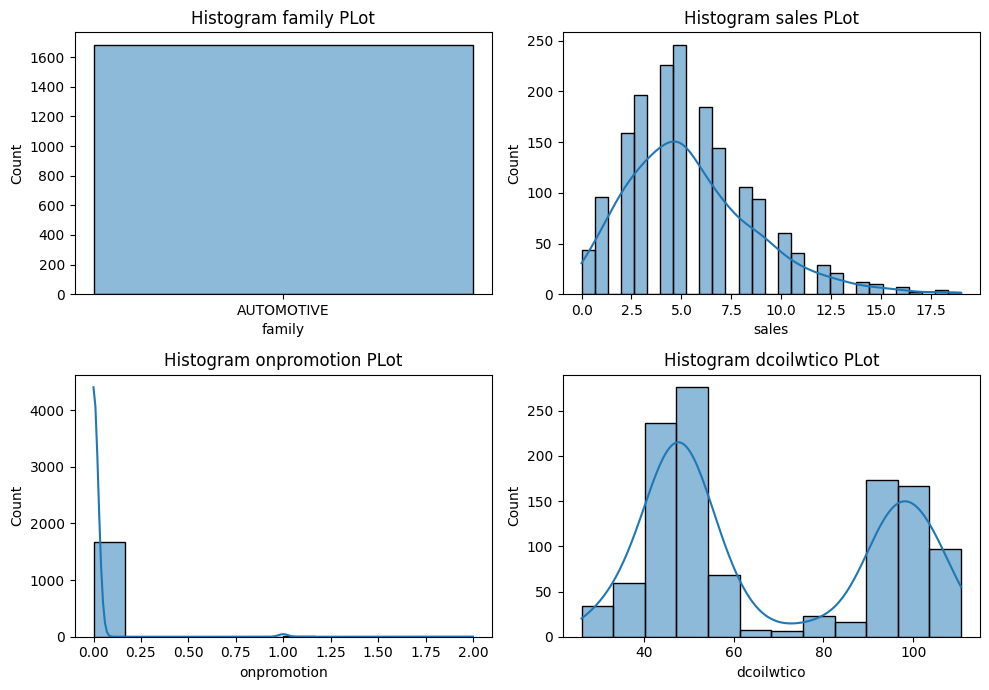

In [ ]:
def histo_plot(df):
  plt.figure(figsize=(10,7))
  for indx, i in enumerate(df.columns):
    plt.subplot(2,2, indx+1)
    sns.histplot(df[i], kde=True)
    plt.title(f'Histogram {i} PLot')
    plt.tight_layout()

  plt.show()

histo_plot(df_automotive)

In [ ]:
df_automotive['dcoilwtico_imputed'] =df_automotive['dcoilwtico'].interpolate()
df_automotive.dropna(subset=['dcoilwtico_imputed'], inplace=True)
df_automotive.head()

<ipython-input-15-6c968564af25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_imputed'] =df_automotive['dcoilwtico'].interpolate()
<ipython-input-15-6c968564af25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive.dropna(subset=['dcoilwtico_imputed'], inplace=True)


,family,sales,onpromotion,dcoilwtico,dcoilwtico_imputed
date,,,,,
2013-01-02,AUTOMOTIVE,6.0,0,93.14,93.140000
2013-01-03,AUTOMOTIVE,4.0,0,92.97,92.970000
2013-01-04,AUTOMOTIVE,6.0,0,93.12,93.120000
2013-01-05,AUTOMOTIVE,4.0,0,NaN,93.146667
2013-01-06,AUTOMOTIVE,10.0,0,NaN,93.173333


### Imputasi Gaussian Mixture Model (GMM)

In [ ]:
# hapus Nan
dcoilwtico_clean = df_automotive[['dcoilwtico']].dropna()

# Clustering dcoilwtico
gmm = GaussianMixture(n_components=2, random_state=7)
gmm.fit(dcoilwtico_clean)
prediction_class = gmm.predict(dcoilwtico_clean)
df_automotive['cluster_dcoilwtico'] = pd.NA
df_automotive.loc[dcoilwtico_clean.index, 'cluster_dcoilwtico'] = prediction_class
df_automotive.head(10)

<ipython-input-16-0f8c5e6207d6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['cluster_dcoilwtico'] = pd.NA


,family,sales,onpromotion,dcoilwtico,dcoilwtico_imputed,cluster_dcoilwtico
date,,,,,,
2013-01-02,AUTOMOTIVE,6.0,0,93.14,93.140000,0
2013-01-03,AUTOMOTIVE,4.0,0,92.97,92.970000,0
2013-01-04,AUTOMOTIVE,6.0,0,93.12,93.120000,0
2013-01-05,AUTOMOTIVE,4.0,0,NaN,93.146667,<NA>
2013-01-06,AUTOMOTIVE,10.0,0,NaN,93.173333,<NA>
2013-01-07,AUTOMOTIVE,7.0,0,93.20,93.200000,0
2013-01-08,AUTOMOTIVE,5.0,0,93.21,93.210000,0
2013-01-09,AUTOMOTIVE,5.0,0,93.08,93.080000,0
2013-01-10,AUTOMOTIVE,2.0,0,93.81,93.810000,0


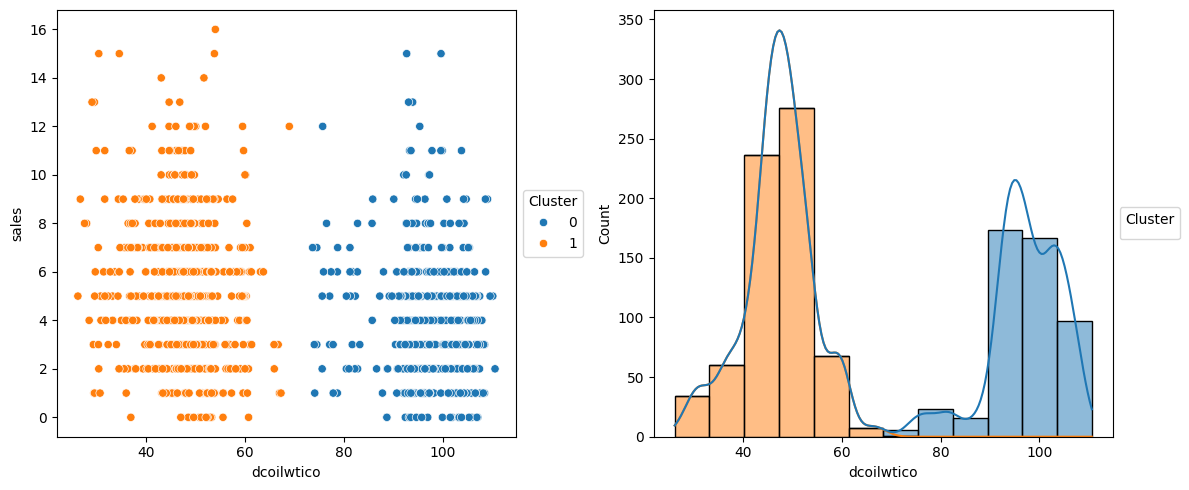

In [ ]:
# Menampilkan overview kolom dcoilwtico berdasarkan cluster
df_filtered = df_automotive.dropna(subset=['cluster_dcoilwtico'])

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Membuat scatter plot tanpa nilai NaN di 'hue'
sns.scatterplot(x=df_filtered['dcoilwtico'],
                y=df_filtered['sales'],
                hue=df_filtered['cluster_dcoilwtico'],
                ax=ax[0])

# Membuat scatter plot tanpa nilai NaN di 'hue'
sns.histplot(x=df_filtered['dcoilwtico'],
             hue=df_filtered['cluster_dcoilwtico'],
             multiple='stack',
             kde=True,
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# cluster data yang nilainya NAN
df_automotive['cluster_dcoilwtico'] = df_automotive.apply(lambda row: 1 if (row['dcoilwtico'] >= 26 and row['dcoilwtico'] < 71) else 0, axis=1)
df_automotive['cluster_dcoilwtico'].value_counts()

<ipython-input-18-0062fc41c554>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['cluster_dcoilwtico'] = df_automotive.apply(lambda row: 1 if (row['dcoilwtico'] >= 26 and row['dcoilwtico'] < 71) else 0, axis=1)


,count
cluster_dcoilwtico,
0,1001
1,682


In [ ]:
# imputasi dengan median dari masing2 cluster
df_automotive['dcoilwtico_imputed'] = df_automotive.apply(lambda row:
                                                          df_automotive[df_automotive['cluster_dcoilwtico'] == row['cluster_dcoilwtico']]['dcoilwtico'].median() if np.isnan(row['dcoilwtico']) else row['dcoilwtico'], axis=1)

<ipython-input-19-f0838781e23f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_imputed'] = df_automotive.apply(lambda row:


In [ ]:
df_automotive.isnull().sum()

,0
family,0
sales,0
onpromotion,0
dcoilwtico,520
dcoilwtico_imputed,0
cluster_dcoilwtico,0


In [ ]:
df_automotive.drop(columns=['dcoilwtico','family','cluster_dcoilwtico'], inplace=True)
df_automotive.head()

<ipython-input-21-427b90620f5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive.drop(columns=['dcoilwtico','family','cluster_dcoilwtico'], inplace=True)


,sales,onpromotion,dcoilwtico_imputed
date,,,
2013-01-02,6.0,0,93.14
2013-01-03,4.0,0,92.97
2013-01-04,6.0,0,93.12
2013-01-05,4.0,0,97.30
2013-01-06,10.0,0,97.30


In [ ]:
df_automotive['onpromotion'].value_counts()

,count
onpromotion,
0,1665
1,17
2,1


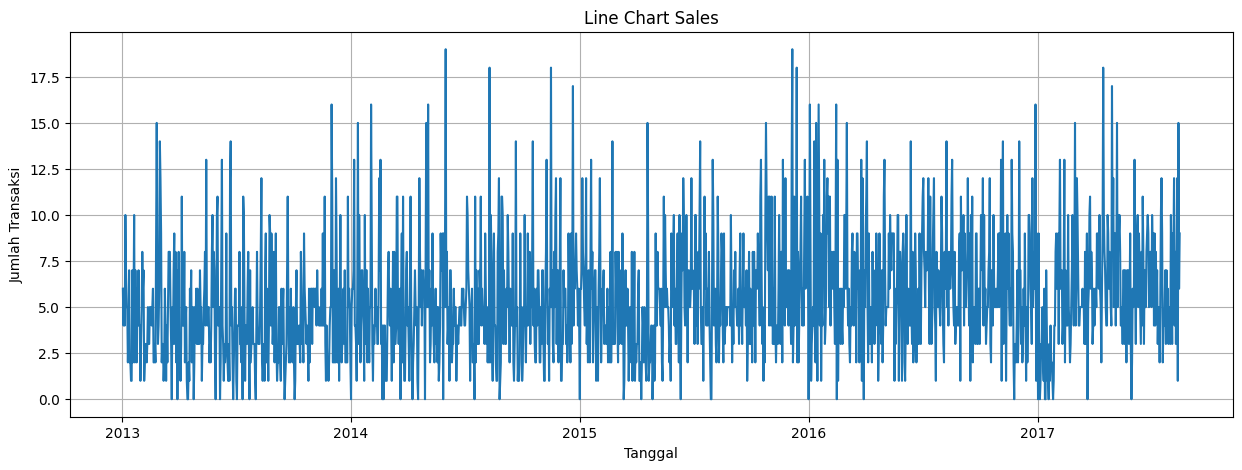

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df_automotive['sales'])
plt.title('Line Chart Sales')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
# split data berdasarkan tahun
df_2017 = df_automotive.loc['2017']
df_2016 = df_automotive.loc['2016']
df_2015 = df_automotive.loc['2015']
df_2014 = df_automotive.loc['2014']
df_2013 = df_automotive.loc['2013']

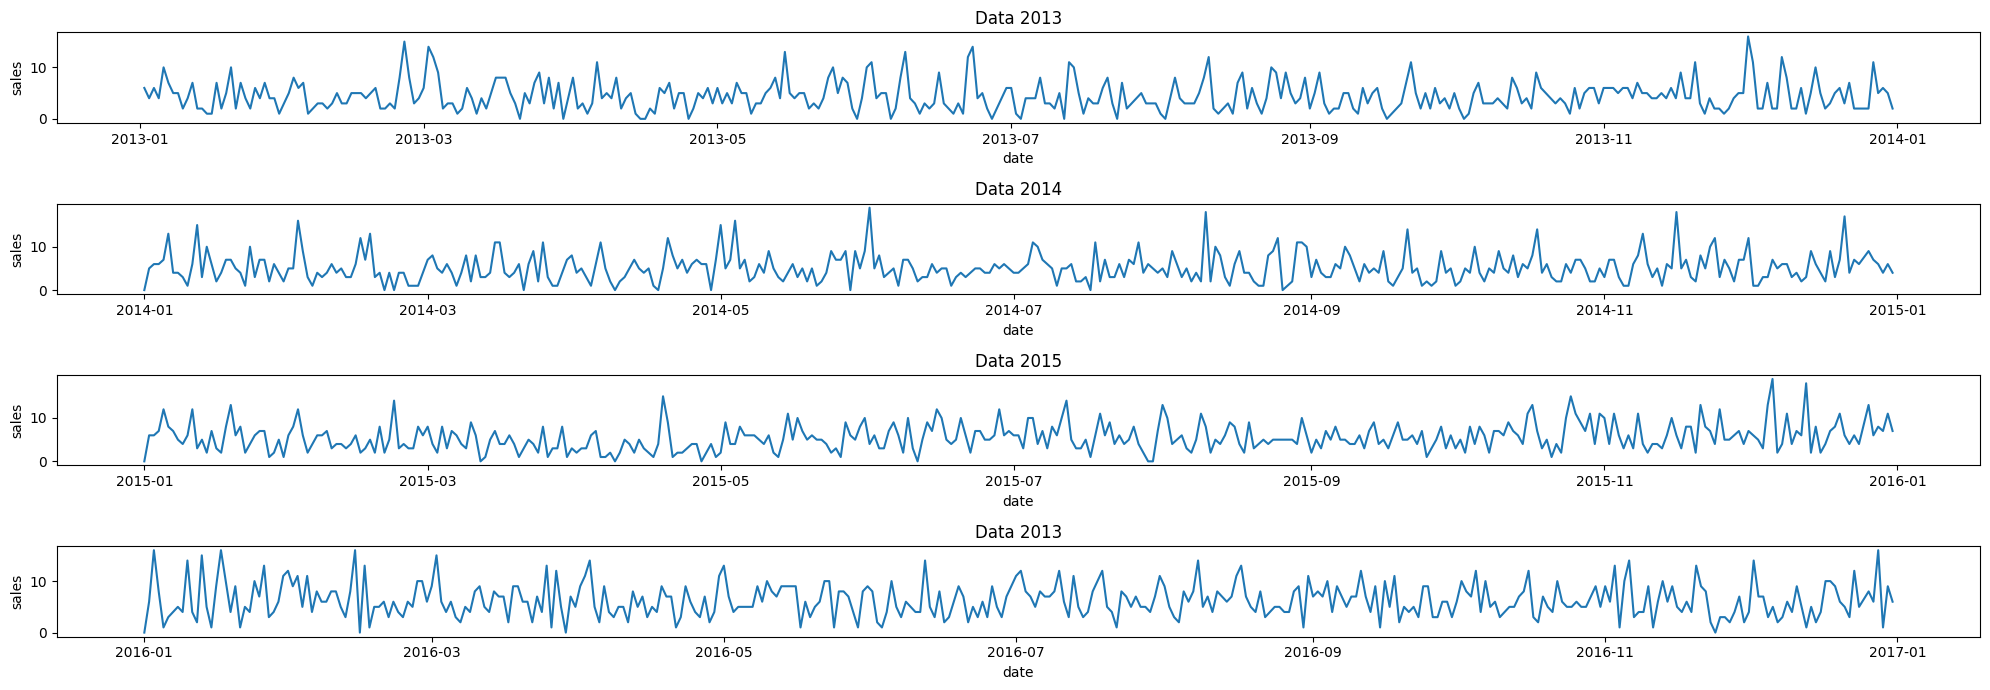

In [ ]:
fig, ax = plt.subplots(4, 1 , figsize=(20,7))

sns.lineplot(x=df_2013.index, y=df_2013['sales'], ax=ax[0])
ax[0].set_title('Data 2013')

sns.lineplot(x=df_2014.index, y=df_2014['sales'], ax=ax[1])
ax[1].set_title('Data 2014')

sns.lineplot(x=df_2015.index, y=df_2015['sales'], ax=ax[2])
ax[2].set_title('Data 2015')

sns.lineplot(x=df_2016.index, y=df_2016['sales'], ax=ax[3])
ax[3].set_title('Data 2013')

plt.tight_layout()
plt.show()

<ipython-input-26-5124d653f135>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_automotive.index.year, y='sales', data=df_automotive, palette='viridis')


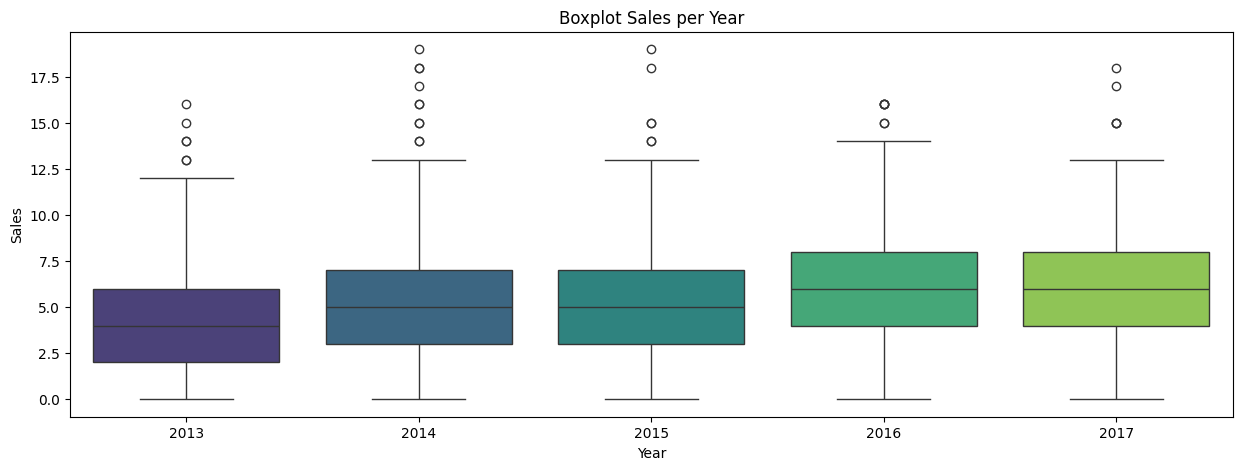

In [ ]:
# Visualisasi data  boxplot
plt.figure(figsize=(15, 5))
sns.boxplot(x=df_automotive.index.year, y='sales', data=df_automotive, palette='viridis')
plt.title('Boxplot Sales per Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Fungsi untuk melakukan ADF test dan mencetak hasilnya
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('')

# Lakukan ADF test untuk setiap variabel
adf_test(df_automotive['sales'], title='Sales')
adf_test(df_automotive['onpromotion'], title='On Promotion')
adf_test(df_automotive['dcoilwtico_imputed'], title='Dcoilwtico')

Augmented Dickey-Fuller Test: Sales
ADF Test Statistic               -5.633123
p-value                           0.000001
#Lags Used                       20.000000
Number of Observations Used    1662.000000
Critical Value (1%)              -3.434291
Critical Value (5%)              -2.863281
Critical Value (10%)             -2.567697

Augmented Dickey-Fuller Test: On Promotion
ADF Test Statistic            -7.678347e+00
p-value                        1.527365e-11
#Lags Used                     1.300000e+01
Number of Observations Used    1.669000e+03
Critical Value (1%)           -3.434274e+00
Critical Value (5%)           -2.863273e+00
Critical Value (10%)          -2.567693e+00

Augmented Dickey-Fuller Test: Dcoilwtico
ADF Test Statistic               -1.131404
p-value                           0.702387
#Lags Used                       24.000000
Number of Observations Used    1658.000000
Critical Value (1%)              -3.434300
Critical Value (5%)              -2.863285
Critical Va

In [ ]:
df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()

# Lakukan ADF test pada variabel yang telah di-differencing
adf_test(df_automotive['dcoilwtico_diff'], title='Dcoilwtico Differenced')

Augmented Dickey-Fuller Test: Dcoilwtico Differenced


<ipython-input-28-99605cb4a892>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_automotive['dcoilwtico_diff'] = df_automotive['dcoilwtico_imputed'].diff().dropna()


ADF Test Statistic            -1.093472e+01
p-value                        9.624545e-20
#Lags Used                     2.300000e+01
Number of Observations Used    1.658000e+03
Critical Value (1%)           -3.434300e+00
Critical Value (5%)           -2.863285e+00
Critical Value (10%)          -2.567699e+00



In [ ]:
# Hapus baris yang memiliki nilai NaN pada kolom 'dcoilwtico_diff'
df_automotive_new = df_automotive.dropna(subset=['dcoilwtico_diff'])

# Tampilkan DataFrame baru
df_automotive_new.head()

,sales,onpromotion,dcoilwtico_imputed,dcoilwtico_diff
date,,,,
2013-01-03,4.0,0,92.97,-0.17
2013-01-04,6.0,0,93.12,0.15
2013-01-05,4.0,0,97.30,4.18
2013-01-06,10.0,0,97.30,0.00
2013-01-07,7.0,0,93.20,-4.10


In [ ]:
df_automotive_new1 = df_automotive_new[['sales','onpromotion','dcoilwtico_diff']]
df_automotive_new1.head()

,sales,onpromotion,dcoilwtico_diff
date,,,
2013-01-03,4.0,0,-0.17
2013-01-04,6.0,0,0.15
2013-01-05,4.0,0,4.18
2013-01-06,10.0,0,0.00
2013-01-07,7.0,0,-4.10


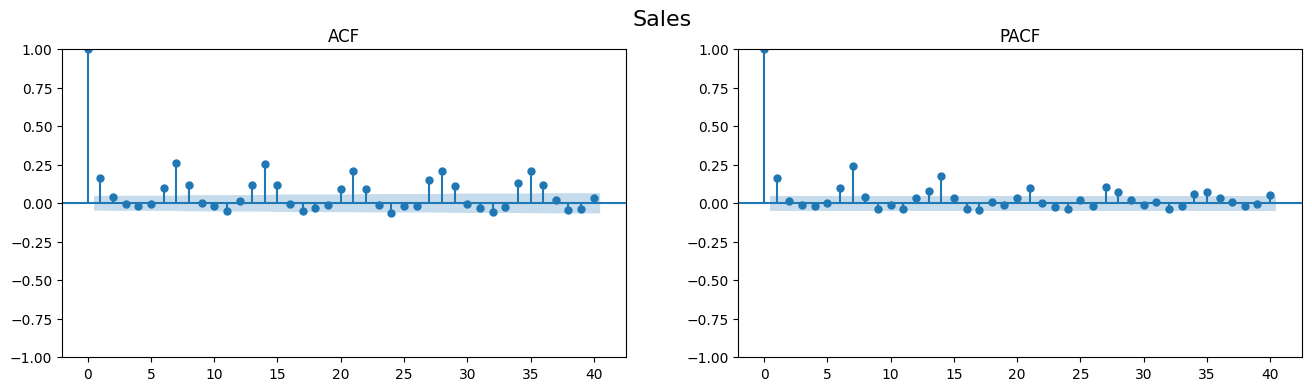

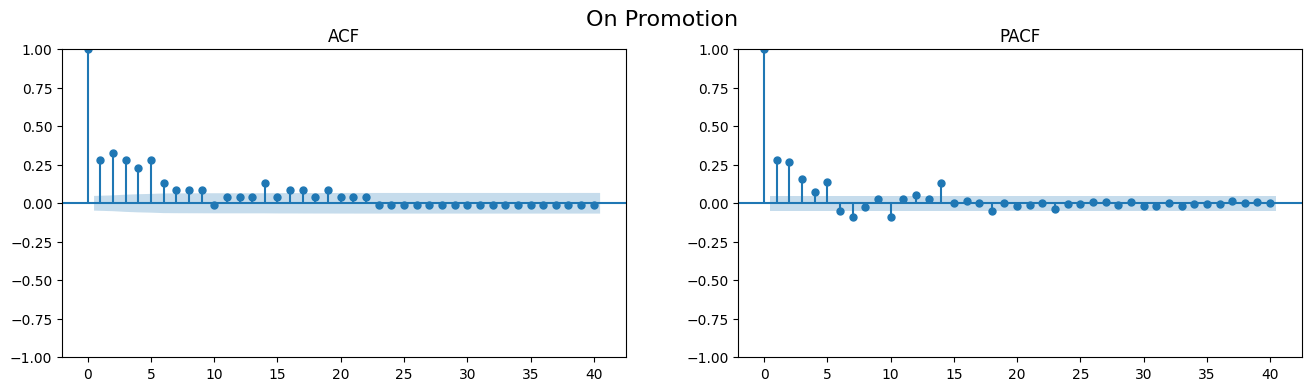

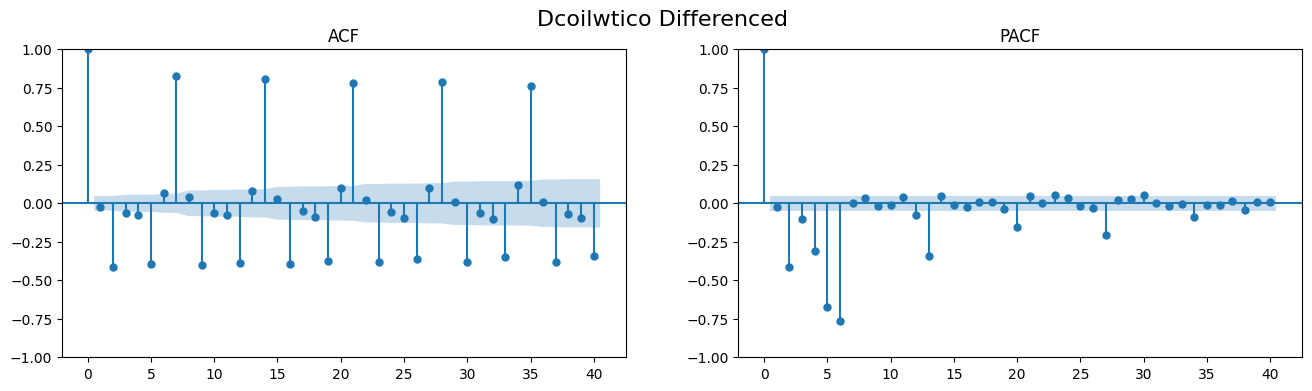

In [ ]:
import statsmodels.api as sm

# Fungsi untuk plot ACF dan PACF
def plot_acf_pacf(series, lags=40, title=''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(title, fontsize=16)

    # Plot ACF
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title('ACF')

    # Plot PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    axes[1].set_title('PACF')

    plt.show()

# Plot ACF dan PACF untuk masing-masing variabel
plot_acf_pacf(df_automotive_new1['sales'], title='Sales')
plot_acf_pacf(df_automotive_new1['onpromotion'], title='On Promotion')
plot_acf_pacf(df_automotive_new1['dcoilwtico_diff'], title='Dcoilwtico Differenced')

In [ ]:
df['week'] = df.index.isocalendar().week

In [ ]:
df_automotive_new1.loc[:, 'dayofweek'] = df_automotive_new1.index.dayofweek
df_automotive_new1.head()

,sales,onpromotion,dcoilwtico_diff,dayofweek
date,,,,
2013-01-03,4.0,0,-0.17,3
2013-01-04,6.0,0,0.15,4
2013-01-05,4.0,0,4.18,5
2013-01-06,10.0,0,0.00,6
2013-01-07,7.0,0,-4.10,0


In [ ]:
df_automotive_new1.describe()

,sales,onpromotion,dcoilwtico_diff,dayofweek
count,1682.000000,1682.000000,1682.000000,1682.000000
mean,5.462545,0.011296,-0.027093,2.998811
std,3.256453,0.111198,21.195265,2.001784
min,0.000000,0.000000,-68.830000,0.000000
25%,3.000000,0.000000,-0.970000,1.000000
50%,5.000000,0.000000,0.000000,3.000000
75%,7.000000,0.000000,0.917500,5.000000
max,19.000000,2.000000,67.980000,6.000000


In [ ]:
# evaluate stasioner
result = adfuller(df_automotive['sales'])
print(f'ADF satistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF satistic: -5.633123194827087
p-value: 1.0781125253064122e-06


In [ ]:
df['week'] = df.index.isocalendar().week

**Note** : Data tidak stasioner

## Modeling

### ARIMA

In [ ]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = df_automotive_new1.drop('sales', axis=1)
y = df_automotive_new1['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=42, shuffle=False)

model = ARIMA(y_train, order=(2,1,0))
model_fit = model.fit()

y_pred_train = model_fit.predict(start=0, end=len(y_train)-1)
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test)-1)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

evaluation_df_ARIMA = pd.DataFrame({
    'Family': ['AUTOMOTIVE'],
    'RMSE Train': [rmse_train],
    'RMSE Test': [rmse_test],
    'MAE Train': [mae_train],
    'MAE Test': [mae_test]
})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

### LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_automotive_new1[['sales', 'onpromotion', 'store_nbr', 'weekly']])

train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 10

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=75, batch_size=20, verbose=1)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((len(y_train), 3))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 3))), axis=1))[:,0]

y_pred_train = scaler.inverse_transform(np.concatenate((y_pred_train.reshape(-1, 1), np.zeros((len(y_pred_train), 3))), axis=1))[:,0]
y_pred_test = scaler.inverse_transform(np.concatenate((y_pred_test.reshape(-1, 1), np.zeros((len(y_pred_test), 3))), axis=1))[:,0]

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

evaluation_df_LSTM = pd.DataFrame({
    'Family': ['AUTOMOTIVE'],
    'RMSE Train': [rmse_train],
    'RMSE Test': [rmse_test],
    'MAE Train': [mae_train],
    'MAE Test': [mae_test]
})

Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0536
Epoch 2/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308
Epoch 3/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0307
Epoch 4/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279
Epoch 5/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0253
Epoch 6/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0260
Epoch 7/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0251
Epoch 8/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0247
Epoch 9/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231
Epoch 10/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0240
Epoch 11/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221
Epoch 12/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0229
Epoch 13/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226
Epoch 14/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0230
Epoch 15/75
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0231
Epoch 16/75
67/67 ━━━━━━━━━━

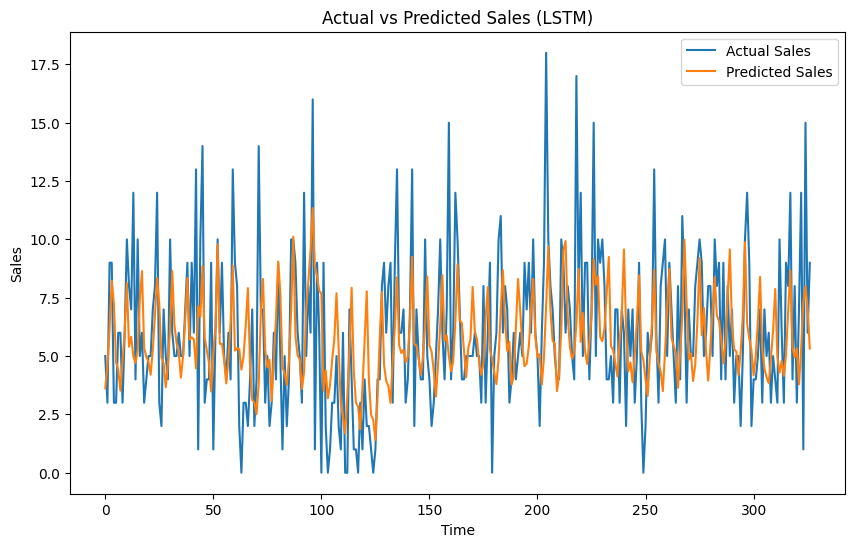

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Sales')
plt.plot(y_pred_test, label='Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales (LSTM)')
plt.legend()
plt.show()

## Model Comparison

In [ ]:
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: darkblue' if v else '' for v in is_min]

evaluation_df = pd.concat([evaluation_df_ARIMA, evaluation_df_LSTM], keys=['ARIMA', 'LSTM'])
evaluation_df = evaluation_df.reset_index()
evaluation_df = evaluation_df.rename(columns={'level_0': 'Model'})
evaluation_df = evaluation_df.drop(columns='level_1')

styled_df = evaluation_df.style.apply(highlight_min, axis=0, subset=['RMSE Train', 'RMSE Test', 'MAE Train', 'MAE Test'])

display(styled_df)

,Model,Family,RMSE Train,RMSE Test,MAE Train,MAE Test
0,ARIMA,AUTOMOTIVE,3.659954,2.046828,2.855571,2.046828
1,LSTM,AUTOMOTIVE,2.789891,3.047711,2.140801,2.379863


Result: Berdasarkan modeling yang telah dibuat, LSTM adalah model paling baik karena mempunyai nilai over fitting yang lebih kecil dibading dengan model ARIMA, walau nilai RSME dan MAE Test sedikit lebih tinggi dari ARIMA